Microsoft AI Rangers Demo
# Blood Cell Object Detection with AzureML Automatd Machine Learning

<img src="images/blood.jpg" width=600 />

__ In this notebook__

- Medical Imaging as a non-trivial object detection use case
- Images as AML dataset incl. versioning
- Training of YOLOv5 baseline model plus model / hyperparameter search using AutoML
- Tracking of meaningful metrics
- Model Management in Azure ML
- Deployment of trained model to AKS

# Blood cell object detection use case

The BCCD Dataset is a small-scale dataset for blood cells detection.

The original data and annotations provided by cosmicad and akshaylamba. The original dataset is re-organized into VOC format. The BCCD Dataset is licensed under the MIT licence.

You can see a example of the labeled cell image. There are three classes :

- Red Blood Cell (RBC)
- White Blood Cell (WBC)
- Platelets

<img src="images/bccd-example.jpg" width=1000 />

You can find the dataset under this location: https://www.kaggle.com/surajiiitm/bccd-dataset
We store the datasat as zip-file __bccd.zip__ in a local folder named __datasets__.

The archive contains a folder named BCCD with the following subfolders:
- images: blood cell images in jpg format
- annotations: xml annotations in Pascal VOC format including classed and bounding boxes for each image


# Setup
## Installs and imports

In [1]:
# %pip install azureml-train-automl-client==1.35.0

Note: You might need to restart the notebook kernel after installing the packages from within the notebook with the line above, for the packages to be available to use.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

## Connect to Azure ML Workspace

In [3]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()

## Compute target setup
You need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [8]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-clu-nv24v3"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Experiment Setup

In [4]:
from azureml.core import Experiment

experiment_name = 'automl-image-object-detection-blood-cells' 
experiment = Experiment(ws, name=experiment_name)

# Acquire and prepare image data

__Note: If the blood cell data files are already available as a registered dataset in the AML Workspace, you can skip the next 3  cells.__

Execute the following 3 cells only if you run this norebook for the first time or want to recreate the dataset. 

In [ ]:
import os
import urllib
from zipfile import ZipFile

# file exists in current folder
data_file = './datasets/bccd.zip'

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall()
    print('done')

## Convert the downloaded data to JSONL
In this example, the  dataset is annotated in Pascal VOC format, where each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located and also contains information about the bounding boxes and the object labels. In order to use this data to create an AzureML Datset, we first need to convert it to the required JSONL format.

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [ ]:
import json
import os
import xml.etree.ElementTree as ET

src = "./BCCD/"
train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the annotations
annotations_folder = os.path.join(src, "annotations")

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)) + "/" + "images",
        "image_details": {"format": None, "width": None, "height": None},
        "label": []
    }

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for i, filename in enumerate(os.listdir(annotations_folder)):
            if filename.endswith(".xml"):
                print("Parsing " + os.path.join(src, filename))

                root = ET.parse(os.path.join(annotations_folder, filename)).getroot()

                width = int(root.find('size/width').text)
                height = int(root.find('size/height').text)

                labels = []
                for object in root.findall('object'):
                    name = object.find('name').text
                    xmin = object.find('bndbox/xmin').text
                    ymin = object.find('bndbox/ymin').text
                    xmax = object.find('bndbox/xmax').text
                    ymax = object.find('bndbox/ymax').text
                    isCrowd = int(object.find('difficult').text)
                    labels.append({"label": name,
                                   "topX": float(xmin)/width,
                                   "topY": float(ymin)/height,
                                   "bottomX": float(xmax)/width,
                                   "bottomY": float(ymax)/height,
                                   "isCrowd": isCrowd})
                # build the jsonl file
                image_filename = root.find("filename").text
                _, file_extension = os.path.splitext(image_filename)
                json_line = dict(json_line_sample)
                json_line["image_url"] = json_line["image_url"] + "/" + image_filename
                json_line["image_details"]["format"] = file_extension[1:]
                json_line["image_details"]["width"] = width
                json_line["image_details"]["height"] = height
                json_line["label"] = labels

                if i % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
            else:
                print("Skipping unknown file: {}".format(filename))

## Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [ ]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./BCCD', target_path='BCCD')

## Reuse / register file dataset in AzureML
__ Continue here if you want to reuse the registered datasets from a previous run __

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [5]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'BCCDTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('BCCD/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "BCCDValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('BCCD/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)
    
    
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Found the training dataset BCCDTrainingDataset
Found the validation dataset BCCDValidationDataset
Training dataset name: BCCDTrainingDataset
Validation dataset name: BCCDValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.   

This is what the training dataset looks like

In [6]:
training_dataset.to_pandas_dataframe().head()

,image_url,image_details,label
0,StreamInfo(AmlDatastore://BCCD/images/BloodIma...,"{'format': 'jpg', 'width': 416, 'height': 416}","[{'label': 'WBC', 'topX': 0.09615384615384616,..."
1,StreamInfo(AmlDatastore://BCCD/images/BloodIma...,"{'format': 'jpg', 'width': 416, 'height': 416}","[{'label': 'WBC', 'topX': 0.5408653846153846, ..."
2,StreamInfo(AmlDatastore://BCCD/images/BloodIma...,"{'format': 'jpg', 'width': 416, 'height': 416}","[{'label': 'RBC', 'topX': 0.5889423076923077, ..."
3,StreamInfo(AmlDatastore://BCCD/images/BloodIma...,"{'format': 'jpg', 'width': 416, 'height': 416}","[{'label': 'RBC', 'topX': 0.5649038461538461, ..."
4,StreamInfo(AmlDatastore://BCCD/images/BloodIma...,"{'format': 'jpg', 'width': 416, 'height': 416}","[{'label': 'WBC', 'topX': 0.08653846153846154,..."


# Configure AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones. 
Currently supported model algorithms for object detection:`yolov5`, `fasterrcnn_resnet50_fpn`, `fasterrcnn_resnet34_fpn`, `fasterrcnn_resnet18_fpn`, `retinanet_resnet50_fpn`.

## Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:

In [12]:
from azureml.train.automl import AutoMLImageConfig
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_yolov5 = AutoMLImageConfig(task=ImageTask.IMAGE_OBJECT_DETECTION,
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        validation_data=validation_dataset,
                                        hyperparameter_sampling=GridParameterSampling({'model_name': choice('yolov5')}),
                                        iterations=1)

## Submitting an AutoML run for Image tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train an image model using your training dataset.

In [13]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection-blood-cells,AutoML_535e8ced-d732-411c-9201-c53fda982bf1,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [14]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_535e8ced-d732-411c-9201-c53fda982bf1',
 'target': 'gpu-clu-nv24v3',
 'status': 'Completed',
 'startTimeUtc': '2021-12-06T09:30:34.947992Z',
 'endTimeUtc': '2021-12-06T09:48:22.084671Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-clu-nv24v3',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-image-object-detection-blood-cells","subscription_id":"4eeedd72-d937-4243-86d1-c3982a84d924","resource_group":"harmke-andreas-demo","workspace_name":"harmke-andreas-demo","region":"westeurope","compute_target":"gpu-clu-nv24v3","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation

## Hyperparameter sweeping for your AutoML models for image tasks

In this example, we use the AutoMLImageConfig to train an Object Detection model using `yolov5` and `fasterrcnn_resnet50_fpn`, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When using AutoML for image tasks, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for `learning_rate`, `optimizer`, `lr_scheduler`, etc, to generate a model with the optimal primary metric. If hyperparameter values are not specified, then default values are used for the specified algorithm.  

We use Random Sampling to pick samples from this parameter space and try a total of 20 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.  

We also leverage the Bandit early termination policy that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

In [18]:
from azureml.train.automl import AutoMLImageConfig
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('yolov5'),
            'learning_rate': uniform(0.0001, 0.01),
            'model_size': choice('small', 'medium'),
            'img_size': choice(412, 320),
        },
        {
            'model_name': choice('fasterrcnn_resnet50_fpn'),
            'learning_rate': uniform(0.0001, 0.001),
            'warmup_cosine_lr_warmup_epochs': choice(0, 3),
            'optimizer': choice('sgd', 'adam', 'adamw'),
            'max_size': choice(412, 320), 
        }
    )
}

tuning_settings = {
    'iterations': 20, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'early_termination_policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}

automl_image_config = AutoMLImageConfig(task=ImageTask.IMAGE_OBJECT_DETECTION,
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        validation_data=validation_dataset,
                                        **tuning_settings)

In [19]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection-blood-cells,AutoML_8710b661-2245-43be-a8bd-d9f5f4ae9ade,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_8710b661-2245-43be-a8bd-d9f5f4ae9ade',
 'target': 'gpu-clu-nv24v3',
 'status': 'Completed',
 'startTimeUtc': '2021-12-06T09:54:09.041824Z',
 'endTimeUtc': '2021-12-06T10:32:56.432223Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-clu-nv24v3',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-image-object-detection-blood-cells","subscription_id":"4eeedd72-d937-4243-86d1-c3982a84d924","resource_group":"harmke-andreas-demo","workspace_name":"harmke-andreas-demo","region":"westeurope","compute_target":"gpu-clu-nv24v3","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this one. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab: 

In [21]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection-blood-cells,AutoML_8710b661-2245-43be-a8bd-d9f5f4ae9ade_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


# Register the optimal model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [22]:
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']
model = best_child_run.register_model(model_name = model_name, model_path='outputs/model.pt')

# Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

In [23]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cluster"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="westeurope")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [24]:
from azureml.core.model import InferenceConfig

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

You can then deploy the model as an AKS web service.

In [25]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True)

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name='automl-image-test',
                           overwrite=True)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-12-06 10:33:38+00:00 Creating Container Registry if not exists.
2021-12-06 10:33:38+00:00 Registering the environment.
2021-12-06 10:33:40+00:00 Use the existing image.
2021-12-06 10:33:41+00:00 Checking the status of deployment automl-image-test..
2021-12-06 10:37:12+00:00 Checking the status of inference endpoint automl-image-test.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


# Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [26]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

sample_image = './bccd-testsamples/BloodImage_00003_jpg.rf.8d4037c47a4a76557c729057293e0755.jpg'

# Load image data
data = open(sample_image, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
# print(resp.text)

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image

WBC: [30.394, 197.455, 162.821, 136.676], 0.996
RBC: [125.255, 104.837, 80.634, 68.662], 0.984
RBC: [217.517, 201.383, 106.393, 70.76], 0.976
RBC: [177.697, 313.384, 102.291, 70.32], 0.976
RBC: [246.999, 140.91, 78.869, 68.328], 0.97
RBC: [180.049, 12.987, 85.665, 76.316], 0.97
RBC: [313.227, 103.828, 78.931, 74.335], 0.969
RBC: [1.367, 72.942, 75.312, 79.579], 0.969
RBC: [20.595, 16.862, 103.023, 64.262], 0.968
RBC: [84.372, 140.706, 90.133, 71.197], 0.961
RBC: [345.571, 302.813, 69.66, 83.725], 0.898
RBC: [313.253, 17.146, 91.301, 65.804], 0.896
RBC: [68.518, 317.892, 120.566, 66.389], 0.89
RBC: [226.017, 59.148, 92.8, 86.678], 0.853
Platelets: [228.191, 177.14, 31.312, 24.393], 0.816
RBC: [313.246, 358.686, 71.311, 56.442], 0.715
RBC: [108.08, 367.012, 103.504, 48.988], 0.684
RBC: [313.084, 258.591, 84.227, 66.486], 0.659
Platelets: [370.261, 3.473, 37.933, 24.462], 0.631
RBC: [251.132, 355.654, 76.757, 59.697], 0.626


<Figure size 1296x864 with 0 Axes>

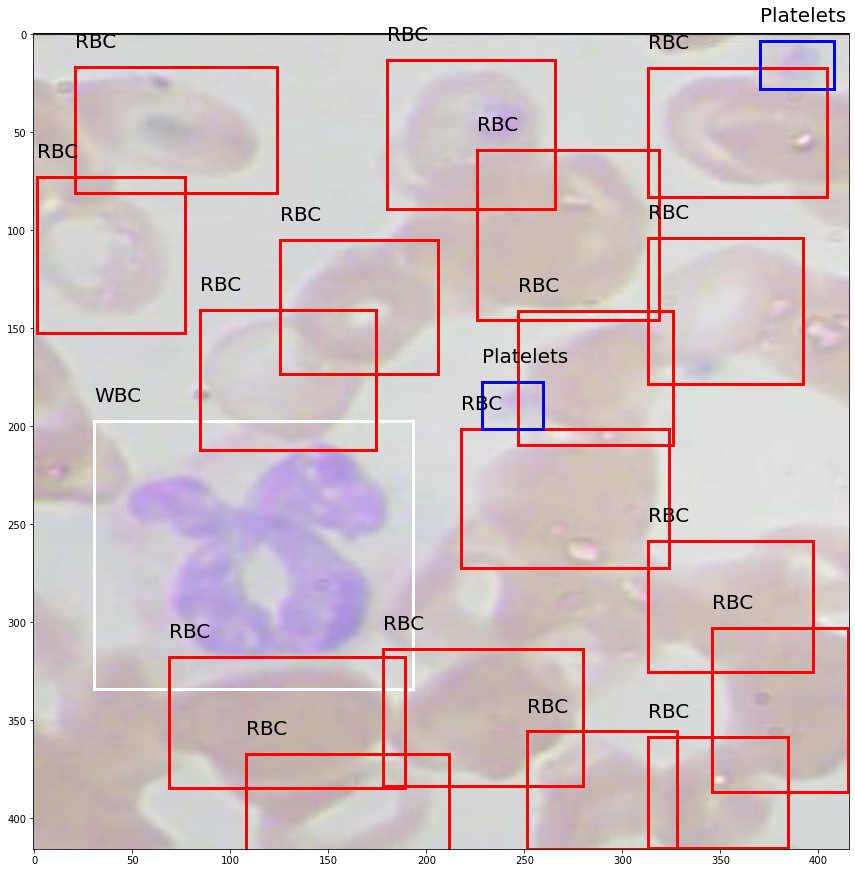

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection 
detections = json.loads(resp.text)

colmap = {'RBC' : 'red',
          'WBC' : 'white',
          'Platelets' : 'blue'}

for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            "{}: [{}, {}, {}, {}], {}".format(
                detect["label"],
                round(topleft_x, 3),
                round(topleft_y, 3),
                round(width, 3),
                round(height, 3),
                round(conf_score, 3),
            )
        )

        color = np.random.rand(3) #'red'
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=colmap[label],facecolor='none')

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color='black', fontsize=20)

plt.show()